In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:
# класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
        
        
# класс листа
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction
    
    
def get_subsample(len_sample):
    
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for i in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample
    
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity


# Расчет качества
def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels


# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [3]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

# Функция классификации отдельного объекта
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
# функция формирования предсказания по выборке на одном дереве
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

# предсказание голосованием деревьев
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [4]:
# функция доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0



##### Реализуем:
* **функцию бустрепа с запоминанием не вошедших в каждую выборку индексов**
* **функцию формирования случайного леса с учетом out of bag оценки**
* **вычисление самой оценки**

In [5]:
def get_bootstrap(data, labels, N, out_of_bag):
    
    random.seed(42)
    n_samples = data.shape[0]
    bootstrap = []
    out_examples = []
    
    for i in range(N):
        bs_data = np.zeros(data.shape)
        bs_labels = np.zeros(labels.shape)
        indexes = []
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            indexes.append(sample_index)
            bs_data[j] = data[sample_index]
            bs_labels[j] = labels[sample_index]
            
        bootstrap.append((bs_data, bs_labels))
        
        if out_of_bag:
            out_indexes = [idx for idx in range(n_samples) if idx not in set(indexes)]
            out_data = data[out_indexes]
            out_labels = labels[out_indexes]
            out_examples.append((out_data, out_labels))
        
    return bootstrap, out_examples

In [6]:
def random_forest(data, labels, n_trees, out_of_bag=False):
    forest = []
    bootstrap, out_examples = get_bootstrap(data, labels, n_trees, out_of_bag=out_of_bag)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    if out_of_bag:
        accuracy = 0
        for i in range(n_trees):
            accuracy += bag_accuracy(out_examples[i], forest[i])
        
        accuracy = accuracy / n_trees
        return forest, accuracy
    
    return forest

In [7]:
def bag_accuracy(out_examples, tree):
    answers = predict(out_examples[0], tree)
    accuracy = accuracy_metric(out_examples[1], answers)
    return accuracy

Построим датасет

In [8]:
classification_data, classification_labels = datasets.make_classification(n_samples=300,
                                                                          n_features=2, n_informative=1, 
                                                                          n_classes=2, n_redundant=0, 
                                                                          n_clusters_per_class=1,
                                                                          random_state=42)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(classification_data, classification_labels, 
                                                                    test_size=0.3, random_state=42)

In [10]:
n_trees = 50
forest_1, out_of_bag = random_forest(X_train, y_train, n_trees, out_of_bag=True)

print(f'Out Of Bag Score: {out_of_bag:.3f}')

Out Of Bag Score: 91.670


In [11]:
n_trees = 100
forest_1, out_of_bag = random_forest(X_train, y_train, n_trees, out_of_bag=True)

print(f'Out Of Bag Score: {out_of_bag:.3f}')

Out Of Bag Score: 90.673


### Построим графики

In [12]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [13]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

Точность случайного леса из 50 деревьев на train: 100.000
Точность случайного леса из 50 деревьев на test: 96.667


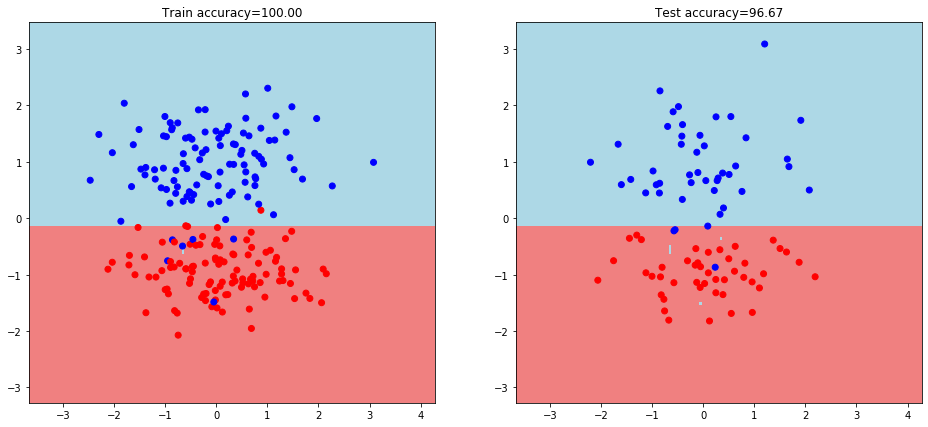

In [14]:
n_trees = 50
forest_3 = random_forest(X_train, y_train, n_trees)

train_answers = tree_vote(forest_3, X_train)
test_answers = tree_vote(forest_3, X_test)

train_accuracy = accuracy_metric(y_train, train_answers)
test_accuracy = accuracy_metric(y_test, test_answers)

print(f'Точность случайного леса из {n_trees} деревьев на train: {train_accuracy:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_accuracy:.3f}')

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(X_train)
mesh_predictions = np.array(tree_vote(forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

Точность случайного леса из 100 деревьев на train: 100.000
Точность случайного леса из 100 деревьев на test: 95.556


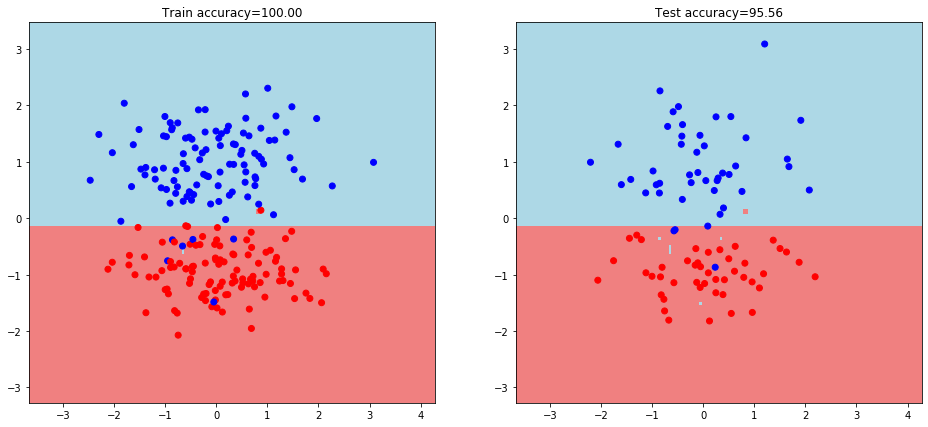

In [15]:
n_trees = 100
forest_3 = random_forest(X_train, y_train, n_trees)

train_answers = tree_vote(forest_3, X_train)
test_answers = tree_vote(forest_3, X_test)

train_accuracy = accuracy_metric(y_train, train_answers)
test_accuracy = accuracy_metric(y_test, test_answers)

print(f'Точность случайного леса из {n_trees} деревьев на train: {train_accuracy:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев на test: {test_accuracy:.3f}')

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(X_train)
mesh_predictions = np.array(tree_vote(forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

Как и было сказано, деревья сильно склонны к подгонке под обучающую выборку

### Сложно даются деревья, принцип работы не так сложен для понимания, но когда приступаю к реализации в голове сразу каша. Приходится каждую минуту подглядывать. 
### Я правильно понимаю, что в 99% никто не использует кастомные модели, а цель курса это понимание работы алгоритмов для настройки гиперпараметров?
### Часто в вашей практике приходится иметь дело с кастомными моделями?